In this notebook a qualitative analysis on the speaker classification task will be carried out. We are going to use dimensionality reduction algorithms (linear and non-linear) and clustering algorithms.

In [45]:
import pandas as pd
import numpy as np
import os
import re
import random
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import itertools
import datetime
import fairseq


from IPython.display import Audio
from rich.progress import track
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
import umap
from sklearn.manifold import TSNE

In [2]:
%run utils_function_2.py

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
df_total = pd.read_csv('~/Voiseed_task/dev_clean/df_total')

In [4]:
df_total_segmented = calculate_raw_signal_segment(df_total, 2)

Output()

In [5]:
df_total_segmented

,raw_signal,ID,SEX,path
0,"[[tensor(0.0024), tensor(0.0021), tensor(0.002...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1,"[[tensor(0.0283), tensor(0.0250), tensor(0.031...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
2,"[[tensor(-0.0002), tensor(-9.1553e-05), tensor...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
3,"[[tensor(0.0446), tensor(0.0475), tensor(0.036...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
4,"[[tensor(-0.0007), tensor(6.1035e-05), tensor(...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
...,...,...,...,...
8387,"[[tensor(0.0131), tensor(0.0094), tensor(0.007...",8842,F,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
8388,"[[tensor(-0.0004), tensor(0.0001), tensor(0.),...",8842,F,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
8389,"[[tensor(0.0036), tensor(0.0004), tensor(-0.00...",8842,F,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
8390,"[[tensor(-0.0382), tensor(-0.0293), tensor(-0....",8842,F,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...


# Features extraction with wav2vec

In this notebook, we are not using the MFCC as a representation of the audio, but we will use the wav2vec2.0 pretrained on Librispeech as 
feature extractor.

In [6]:
# extracting features

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cp_path = '/home/pierobon/Voiseed_task/wav2vec2/wav2vec_large.pt'
#cp_path = '/home/pierobon/Voiseed_task/wav2vec_finetuned/wav2vec_small_10m.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0].to(device)

2021-12-14 16:00:44 | INFO | fairseq.models.wav2vec.wav2vec | Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm

In [7]:
# calculating the embeddings by doing the mean, for each w2v band, over the time dimension
df_total_emb = extract_w2v_mean(model, device, df_total_segmented)

Output()

# DIMENSIONALITY REDUCTION

In the following section, different dimensionality reduction algorithms were used, both linear (umap, PCA) and non-linear (KernelPCA, tSNE). As expected, the non-linear dimensionality reduction algorithms performed better than the others and the best was the tSNE.

# Umap

In [8]:
def compute_umap(data_to_reduce, n_components):
    '''
    This function applies a standard scaler to the input data (data_to_reduce) and then operates a dimensionality
    reduction with the umap.
    
    Input:
    - data_to_reduce = dataframe with the audio embeddings (mean of the w2v band) in the first 512 columns + ID speaker columns 
    + path of the audio file column. Each row represent an audio file.
    - n_components = # components of the umap
    
    Output: dataframe with n_components columns in which are reported the reducted dimensions + ID + path
    '''
    
    sc = StandardScaler()
    data_to_reduce_scaled = sc.fit_transform(data_to_reduce.iloc[:, :512])
    
    reducer = umap.UMAP(n_components=n_components)
    embeddings_u = reducer.fit_transform(data_to_reduce_scaled.iloc[:, :512])
    
    df_embeddings_u = pd.DataFrame(embeddings_u, columns=range(embeddings_u.shape[1]), index=range(embeddings_u.shape[0]))
    df_embeddings_u['ID'] = data_to_reduce.ID.values
    df_embeddings_u['path'] = data_to_reduce.path.values
    
    return df_embeddings_u

# PCA

In [9]:
def compute_PCA(data_to_reduce, n_components):
    '''
    
    This function applies a standard scaler to the input data (data_to_reduce) and then operates a dimensionality
    reduction with the PCA.
    
    Input:
    - data_to_reduce = dataframe with the audio embeddings (mean of the w2v band) in the first 512 columns + ID speaker columns 
    + path of the audio file column. Each row represent an audio file.
    - n_components = # components of the PCA
    
    Output: dataframe with n_components columns in which are reported the reducted dimensions + ID + path
    
    '''
    sc = StandardScaler()
    data_to_reduce_scaled = sc.fit_transform(data_to_reduce.iloc[:, :512])
    
   
    reducer = PCA(n_components=n_components)
    embeddings_pca = reducer.fit_transform(data_to_reduce_scaled)
    
    df_embeddings_pca = pd.DataFrame(embeddings_pca, columns=range(embeddings_pca.shape[1]), index=range(embeddings_pca.shape[0]))
    df_embeddings_pca['ID'] = data_to_reduce.ID.values
    df_embeddings_pca['path'] = data_to_reduce.path.values
    
    return df_embeddings_pca

With umap and PCA, plotting the results of the dimensionality reduction, we were not able to distinguish diffent clusters (based on the speaker ID).

# KernelPCA

In [10]:
def compute_PCA(data_to_reduce, n_components):
    '''
    
    This function applies a standard scaler to the input data (data_to_reduce) and then operates a dimensionality
    reduction with the KernelPCA.
    
    Input:
    - data_to_reduce = dataframe with the audio embeddings (mean of the w2v band) in the first 512 columns + ID speaker columns 
    + path of the audio file column. Each row represent an audio file.
    - n_components = # components of the KernelPCA
    
    Output: dataframe with n_components columns in which are reported the reducted dimensions + ID + path
    
    '''
    sc = StandardScaler()
    data_to_reduce_scaled = sc.fit_transform(data_to_reduce.iloc[:, :512])
    
    reducer = KernelPCA(n_components=n_components)
    embeddings_pca = reducer.fit_transform(data_to_reduce_scaled)
    
    df_embeddings_pca = pd.DataFrame(embeddings_pca, columns=range(embeddings_pca.shape[1]), index=range(embeddings_pca.shape[0]))
    df_embeddings_pca['ID'] = data_to_reduce.ID.values
    df_embeddings_pca['path'] = data_to_reduce.path.values
    
    return df_embeddings_pca

In [11]:
pca_test = compute_PCA(df_total_emb, 2)

<AxesSubplot:xlabel='0', ylabel='1'>

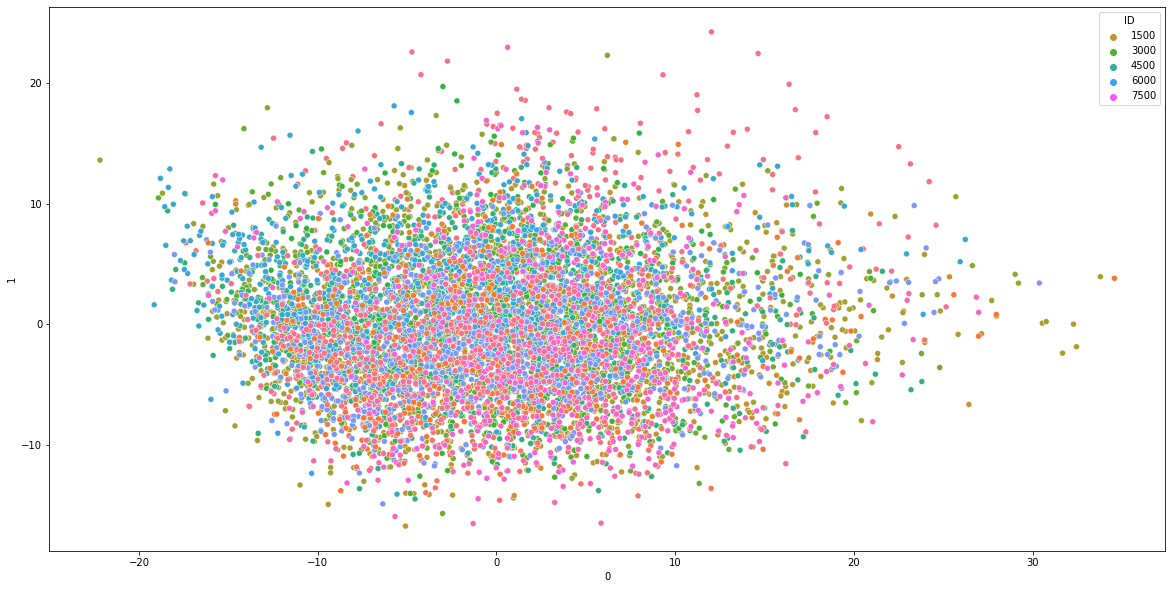

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

sns.scatterplot(ax = ax, data=pca_test, x=0, y=1, hue=pca_test.ID, palette='husl')

# tSNE

In [29]:
def compute_tsne(data_to_reduce, n_components):
    
    '''
    
    This function applies a standard scaler to the input data (data_to_reduce) and then operates a dimensionality
    reduction with the TSNE.
    
    Input:
    - data_to_reduce = dataframe with the audio embeddings (mean of the w2v band) in the first 512 columns + ID speaker columns 
    + path of the audio file column. Each row represent an audio file.
    - n_components = # components of the TSNE
    
    Output: dataframe with n_components columns in which are reported the reducted dimensions + ID + path + color based on the speaker ID
    
    '''
    
    sc = StandardScaler()
    
    # from TSNE documentation, they suggest to apply PCA before TSNE if the number of features of our data is greater than 50 (we have 512 features)
    data_to_reduce_scaled = sc.fit_transform(data_to_reduce.iloc[:, :512])
    pca = PCA(n_components=50)

    data_to_reduce_pca = pca.fit_transform(data_to_reduce_scaled)
    tsne = TSNE(n_components=n_components)

    X_tsne = tsne.fit_transform(data_to_reduce_pca)
    
    df_embeddings_tsne = pd.DataFrame(X_tsne, columns=range(X_tsne.shape[1]), index=range(X_tsne.shape[0]))
    df_embeddings_tsne['ID'] = data_to_reduce.ID.values
    df_embeddings_tsne['path'] = data_to_reduce.path.values
    
    # set the colors fot the further plotting 
    for speaker in df_embeddings_tsne.ID.unique():
        df_embeddings_tsne.loc[df_embeddings_tsne.ID == speaker, 'color'] = random.randint(0, 255)
    
    return df_embeddings_tsne

In [30]:
tsne_test = compute_tsne(df_total_emb, 2)

# n_components = 2

In [31]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [56]:
import plotly.express as px

fig = px.scatter(tsne_test, x=0, y=1, hover_name='ID', labels='ID', color='color')
fig.update_layout(showlegend=False)
fig.show()

The tSNE was the algorithm of dimensionality reduction which performed better with these data. As we can see from the scatter plot, where each point represents an audio segment and the color of the points represents the ID of the speaker, audio files belonging to the same speaker are close to each other. This means, first of all, that the wav2vec representation is very meaningful for summarizing important audio features, and also that this dimensionality reduction technique is able to preserve some important characteristics useful for the speaker classification task.

# n_components = 3

In [33]:
tsne_test = compute_tsne(df_total_emb, 3)

In [34]:
px.scatter_3d(tsne_test, x=0, y=1, z=2,color='color')

 We have also tried to apply the tSNE with n_components = 3 but, plotting the results, the interpretation is easier with 2 components.

# Autoencoder

At the end, we have also tried to apply an autoencoder as a dimensionality reduction algorithm. In other word, the main idea was to build an autoecoder composed by 3 layers, both in the encoder and in the decoder, which accepts as input the embeddings with shape 512 and compress them up to two dimensions in the latent representation. In this way, we wanted to use this latent representation as the new embedding of our audio files but, plotting the results in a scatter plot, we were not able to distinguish different clusters. 
The main problems here are:
- the autoencoder is heavy to train and it takes a lot of time (maybe with more epochs we would obtain better results)
- moving from 512 dimensions to 2 we risk to loose too many information

# CLUSTERING - K-means

Since we already know the number of the speakers (40), wich has to be equal to the number of centroids, we have decided to use k-means

In [35]:
def clustering_kmeans(data):
    
    result = compute_tsne(data, 2)
    
    kmeans = KMeans(
        init="random",
        n_clusters=40, # we can set the number of cluster = 40 because we know that the dataset is composed by 40 speakers
        random_state=SEED
    )
    
    result['cluster'] = kmeans.fit_predict(result.iloc[:, :2])

    # get centroids
    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]
    
    zip_iterator_x = zip(range(40), cen_x)
    centroid_dict_x = dict(zip_iterator_x)
    zip_iterator_y = zip(range(40), cen_y)
    centroid_dict_y = dict(zip_iterator_y)

    # add to result
    result['cen_x'] = result.cluster.map(centroid_dict_x)
    result['cen_y'] = result.cluster.map(centroid_dict_y)
    
    
    return result
    

In [36]:
df_clustering = clustering_kmeans(df_total_emb)

In [41]:
# define and map colors
    
keys_list = range(40)
values_list = random.sample(range(1, 255), 40)
zip_iterator = zip(keys_list, values_list)

color_dict = dict(zip_iterator)

In [42]:
df_clustering['c'] = df_clustering.cluster.map(color_dict)

In [57]:
px.scatter(df_clustering, x=0, y=1, hover_name='ID', color='c')

Visually, the clustering seems to perform well, dividing our points (audio segments) into 40 different clusters, equal to the number of speakers. However, looking at the actual composition of each cluster, it was noted that different speakers are part of the same cluster (even if of different sexes).

In [65]:
df_cluster_analysis = df_clustering.merge(df_total_emb[['SEX', 'ID']], how='left', on='ID')

In [137]:
df_cluster_analysis.groupby(by=['cluster', 'SEX']).count()

0      1     ID   path  color  cen_x  cen_y      c
cluster SEX                                                        
0       F    36726  36726  36726  36726  36726  36726  36726  36726
        M     2823   2823   2823   2823   2823   2823   2823   2823
1       F     4767   4767   4767   4767   4767   4767   4767   4767
        M    43729  43729  43729  43729  43729  43729  43729  43729
2       F    29747  29747  29747  29747  29747  29747  29747  29747
...            ...    ...    ...    ...    ...    ...    ...    ...
37      M    33181  33181  33181  33181  33181  33181  33181  33181
38      F    27411  27411  27411  27411  27411  27411  27411  27411
        M    18166  18166  18166  18166  18166  18166  18166  18166
39      F    32263  32263  32263  32263  32263  32263  32263  32263
        M    13236  13236  13236  13236  13236  13236  13236  13236

[80 rows x 8 columns]

# Listen to the audio tracks belonging to different clusters

In [136]:
df_cluster_analysis[(df_cluster_analysis.cluster ==0)]

,0,1,ID,path,color,cluster,cen_x,cen_y,c,SEX
281447,-59.566021,21.768530,1993,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,124.0,0,-67.732407,28.242224,150,F
281448,-59.566021,21.768530,1993,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,124.0,0,-67.732407,28.242224,150,F
281449,-59.566021,21.768530,1993,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,124.0,0,-67.732407,28.242224,150,F
281450,-59.566021,21.768530,1993,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,124.0,0,-67.732407,28.242224,150,F
281451,-59.566021,21.768530,1993,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,124.0,0,-67.732407,28.242224,150,F
...,...,...,...,...,...,...,...,...,...,...
1569640,-67.034225,22.029551,7850,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,50.0,0,-67.732407,28.242224,150,F
1569641,-67.034225,22.029551,7850,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,50.0,0,-67.732407,28.242224,150,F
1569642,-67.034225,22.029551,7850,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,50.0,0,-67.732407,28.242224,150,F
1569643,-67.034225,22.029551,7850,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,50.0,0,-67.732407,28.242224,150,F


In [138]:
sample = df_cluster_analysis.iloc[281451, :]
audio_tensor, sr = torchaudio.load(sample.path)
Audio(audio_tensor[0,:].numpy().transpose(), rate=sr)

In [139]:
df_cluster_analysis[(df_cluster_analysis.cluster ==10)]

,0,1,ID,path,color,cluster,cen_x,cen_y,c,SEX
6936,-37.808704,-26.580143,1272,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,M
6937,-37.808704,-26.580143,1272,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,M
6938,-37.808704,-26.580143,1272,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,M
6939,-37.808704,-26.580143,1272,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,M
6940,-37.808704,-26.580143,1272,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,M
...,...,...,...,...,...,...,...,...,...,...
1718585,-30.794249,-15.082717,8842,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,F
1718586,-30.794249,-15.082717,8842,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,F
1718587,-30.794249,-15.082717,8842,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,F
1718588,-30.794249,-15.082717,8842,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,121.0,10,-39.813164,-16.043161,21,F


In [140]:
sample = df_cluster_analysis.iloc[6936, :]
audio_tensor, sr = torchaudio.load(sample.path)
Audio(audio_tensor[0,:].numpy().transpose(), rate=sr)

# Conclusion

Listening to the audio of different speakers, but belonging to the same cluster, we noticed a certain similarity in the style and intonation of speech. We can therefore conclude that clustering of this kind, based on such embeddings, is able to highlight differences in style rather than distinguish between the various speakers.